The first thing we do is to import the necessary libraries. As seen in the dataset github repository (https://github.com/RomainLITUD/conflict_resolution_dataset) we need to import the following libraries:

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import pandas as pd
import zarr
import os
from dataset.visual_utils import *

Read and visualize data:

In [2]:
folder_av = 'av'
folder_hv = 'hv'

root_av = './dataset/data_3m/'+folder_av+'/'
root_hv = './dataset/data_3m/'+folder_hv+'/'

log_ids_av = [name for name in os.listdir(root_av) if os.path.isdir(os.path.join(root_av, name))]
log_ids_hv = [name for name in os.listdir(root_hv) if os.path.isdir(os.path.join(root_hv, name))]

print('Number of scenarios for Autonomous Vehicles: ', len(log_ids_av))
print('Number of scenarios for Human-driven Vehicles: ', len(log_ids_hv))

Number of scenarios for Autonomous Vehicles:  5337
Number of scenarios for Human-driven Vehicles:  16094


Read the data:

In [3]:
'''
slices: len = nb_objects + 1, slices[n] and slices[n+1] gives the start/end indices of the n-th object
maps: lanes as NumPy array
type: len = nb_objects, contains 7 numbers with the following meanings:
        -1: Static background
        0: human-driven vehicles
        1: pedestrians
        2: motorcyclists
        3: cyclists
        4: buses
        10: autonomous vehicles
timestep: timestamps in second, timestep[slices[n]: slices[n+1]] give the timestamps for the n-th object
motion: motion state, with 7 dimensions
    motion[slices[n]: slices[n+1]] gives the motion of the n-th object, the 7 features are the following variables in order:
        [x, y, vx, vy, ax, ay, yaw]
        yaw is to the x-axis, between [-pi, pi]
'''
slices, timestep, motion, type, maps = read_scenario(log_ids_av[2441], root_av)

Visualize the data:

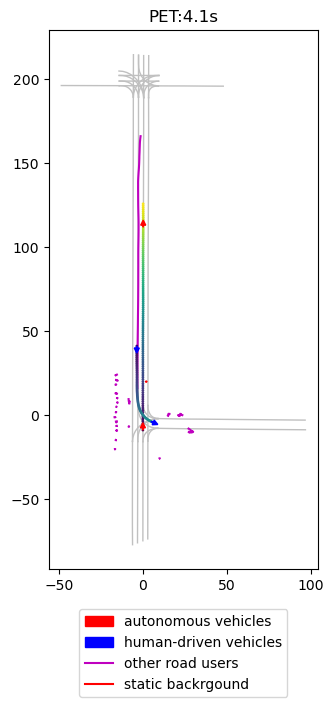

In [4]:
fig, ax = visualize(log_ids_av[25], root_av, other_road_users=True, direction=True)


Filter the data:

The metafile contains the following information:
log_id: string, index of the scenario
[xi_start, yi_start]: float, direction vector of the first* agent recorded in the scenario at the start** time
[xj_start, yj_start]: float, direction vector of the second agent recorded in the scenario at the start time
typei: str, agent type of the first agent recorded in the scenario, being one of {'AV','HV','Pedestrian','Motorcyclist','Cyclist','Bus'}
[xi_end, yi_end]: float, direction vector of the first* agent recorded in the scenario at the end*** time
[xj_end, yj_end]: float, direction vector of the second agent recorded in the scenario at the end time
typej: str, agent type of the second agent recorded in the scenario, being one of {'AV','HV','Pedestrian','Motorcyclist','Cyclist','Bus'}
direction: str, whether the second-passing vehicle moved from the left ('L-R') or the right ('R-L') of the first-passing agent
PET: float, post-encroachment-time
ifirst: bool, whether the first-passing agent is the first agent recorded in the scenario
angle_start: float, angle between the direction vectors of the two agents at the start time
angle_end: float, angle between the direction vectors of the two agents at the end time
start: str, whether the two agents ran parallel (P), crossed (C), or ran opposite (O) to each other before reaching the conflict point
end: str, whether the two agents ran parallel (P), crossed (C), or ran opposite (O) to each other after reaching the conflict point

Notes:
    * Note that the first agent does not necessarily pass the conflict point first.
    ** We consider the start time as 5 seconds before the first-passing agent passed the conflict point, or the start of the record if the time before passing the conflict point is less than 5 seconds.
    *** Similarly, the end time is 5 seconds after the second-passing vehicle passed the conflict point, or the end of the record if the time after passing the conflict point is less than 5 seconds.


We'll load the metafile and filter for intersection scenarios based on the 'angle_start' and 'angle_end' fields, which indicate crossing trajectories:

In [5]:
# Load metafile for autonomous vehicles
metafile_av = pd.read_csv('./dataset/metafile_av.csv')

# Filter for intersection scenarios (crossing trajectories)
intersection_cases = metafile_av[
    ((metafile_av['start'] == 'cross') | (metafile_av['end'] == 'cross')) &
    (metafile_av['typej'] != 'Pedestrian')
]

print(f"Total number of intersection scenarios: {len(intersection_cases)}")

Total number of intersection scenarios: 4237


We define three functions, one to get the scenario filename, one to analyze the scenario and one to visualize the scenario:

In [6]:
def get_scenario_filename(scenario_id, root_path):
    """
    Maps a scenario ID to its corresponding zarr file in the dataset.
    
    Args:
        scenario_id (str): The ID of the scenario to find
        root_path (str): Root directory containing the scenario files
        
    Returns:
        str or None: Filename if found, None if no matching file exists
    """
    zarr_files = [f for f in os.listdir(root_path) if f.endswith('.zarr')]
    
    # First try exact format matching
    target_suffix = f"{int(scenario_id):02d}.zarr"
    matching_files = [f for f in zarr_files if f.endswith(target_suffix)]
    
    if not matching_files:
        # If no exact match, search for any file containing the scenario number
        matching_files = [f for f in zarr_files if str(int(scenario_id)) in f]
    
    if not matching_files:
        print(f"Error: No matching file found for scenario {scenario_id}")
        return None
        
    return matching_files[0]

def analyze_intersection_scenario(scenario_id, root_path):
    """
    Analyzes a single intersection scenario and extracts relevant features for conflict detection.
    
    Args:
        scenario_id (str): The ID of the scenario to analyze
        root_path (str): Root directory containing the scenario files
        
    Returns:
        dict or None: Dictionary containing scenario features if successful:
            - scenario_id: ID of the analyzed scenario
            - trajectory_length: Number of timesteps in the scenario
            - vehicle_count: Number of vehicles in the scenario
            - motion_data: Vehicle motion states (position, velocity, acceleration, yaw)
            - timestep: Timestamps for each motion state
            - slices: Indices marking different vehicles' data
            - type_data: Vehicle type information
        Returns None if analysis fails
    """
    filename = get_scenario_filename(scenario_id, root_path)
    if filename is None:
        print(f"Error: No matching file found for scenario {scenario_id}")
        return None
    
    try:
        slices, timestep, motion, type_data, maps = read_scenario(filename, root_path)
        
        features = {
            'scenario_id': scenario_id,
            'trajectory_length': len(timestep),
            'vehicle_count': len(type_data),
            'motion_data': motion,
            'timestep': timestep,
            'slices': slices,
            'type_data': type_data
        }
        return features
    except Exception as e:
        print(f"Error analyzing scenario {scenario_id}: {str(e)}")
        return None

def visualize_scenario(scenario_id, root_path):
    """Visualizes a single scenario with trajectory information."""
    try:
        filename = get_scenario_filename(scenario_id, root_path)
        if filename:
            fig, ax = visualize(filename, root_path, 
                              other_road_users=True, 
                              direction=True)
            plt.title(f'Scenario {scenario_id}')
            return fig, ax
        return None, None
    except Exception as e:
        print(f"Error visualizing scenario {scenario_id}: {str(e)}")
        return None, None

Now, we can analyze a few sample scenarios:


Analyzing sample scenarios:

Processing scenario 0
Successfully analyzed scenario:
- Trajectory length: 1680
- Number of vehicles: 44

Processing scenario 1
Successfully analyzed scenario:
- Trajectory length: 510
- Number of vehicles: 7

Processing scenario 2
Successfully analyzed scenario:
- Trajectory length: 539
- Number of vehicles: 5

Processing scenario 3
Successfully analyzed scenario:
- Trajectory length: 1127
- Number of vehicles: 15

Processing scenario 4
Successfully analyzed scenario:
- Trajectory length: 1281
- Number of vehicles: 22


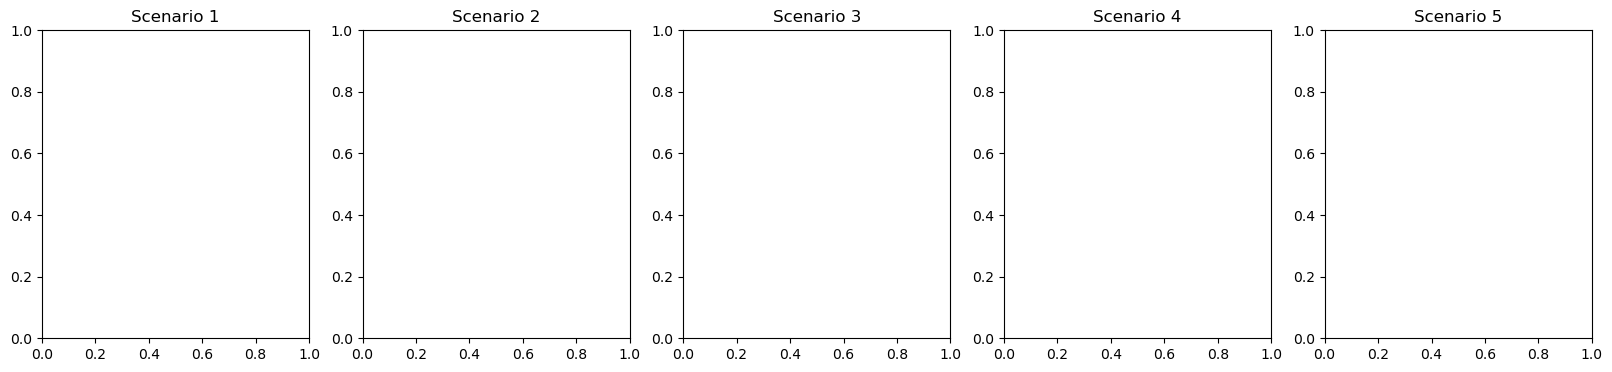

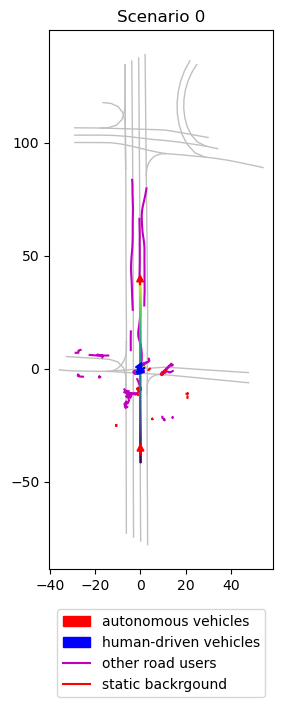

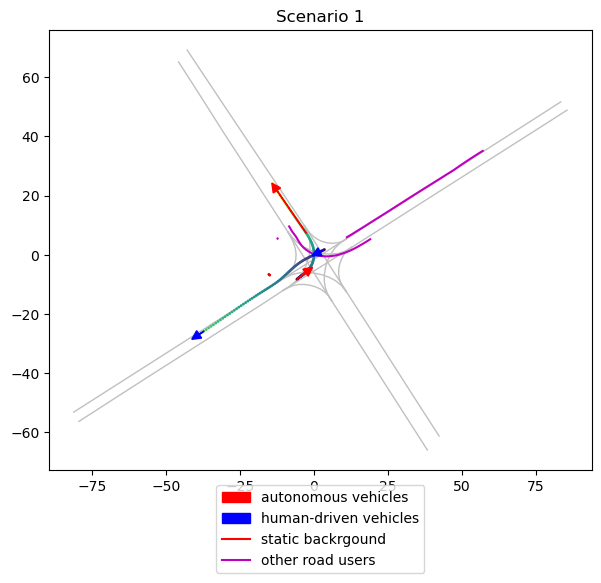

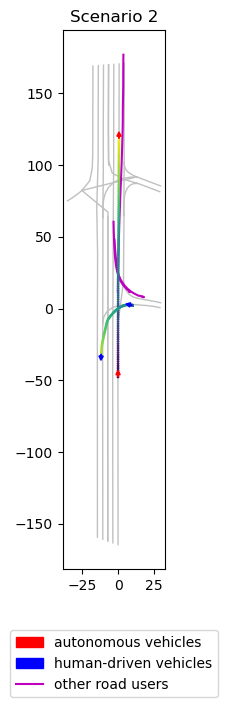

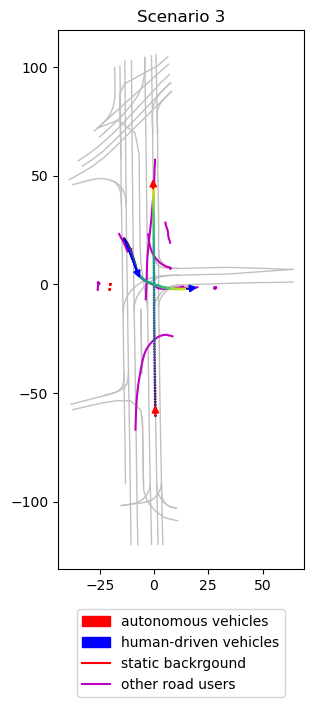

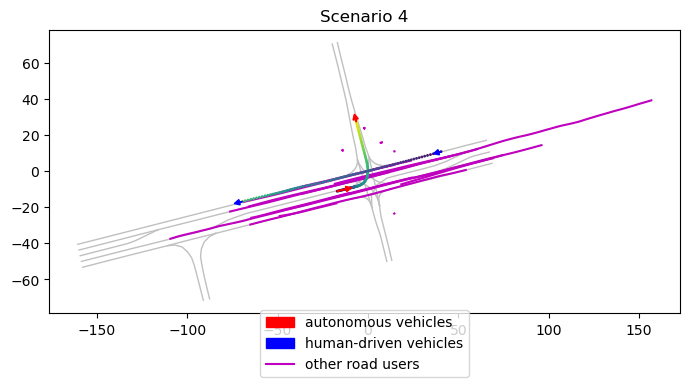

In [7]:
sample_size = 5
sample_scenarios = intersection_cases['log_id'].iloc[:sample_size]

print("\nAnalyzing sample scenarios:")
for scenario_id in sample_scenarios:
    print(f"\nProcessing scenario {scenario_id}")
    features = analyze_intersection_scenario(scenario_id, root_av)
    
    if features:
        print(f"Successfully analyzed scenario:")
        print(f"- Trajectory length: {features['trajectory_length']}")
        print(f"- Number of vehicles: {features['vehicle_count']}")
    else:
        print("Analysis failed")

# Visualize sample scenarios
fig, axs = plt.subplots(1, min(5, len(sample_scenarios)), figsize=(20, 4))
if not isinstance(axs, np.ndarray):
    axs = [axs]

for i, scenario_id in enumerate(sample_scenarios[:5]):
    _, _ = visualize_scenario(scenario_id, root_av)
    if i < len(axs):
        axs[i].set_title(f'Scenario {i+1}')

plt.tight_layout()
plt.show()


Now we can do the conflict analysis for the intersection scenarios:

In [8]:
# Constants for conflict analysis
CONFLICT_THRESHOLDS = {
    'TTC_CRITICAL': 2.0,     # Critical Time-to-Collision (seconds)
    'PET_CRITICAL': 1.0,     # Critical Post-Encroachment Time (seconds)
    'ANGLE_THRESHOLD': {
        'CROSSING': 45,      # Minimum angle for crossing conflict (degrees)
        'HEAD_ON': 150       # Minimum angle for head-on conflict (degrees)
    },
    'DISTANCE_CRITICAL': 5.0 # Critical distance (meters)
}

class ConflictType:
    """Possible conflict types in autonomous driving scenarios"""
    CROSSING = "crossing"           # Trajectories intersect at an angle
    REAR_END = "rear_end"          # Following vehicle conflicts with leading vehicle
    HEAD_ON = "head_on"            # Vehicles approaching from opposite directions
    MERGING = "merging"            # Vehicle merging into traffic
    NO_CONFLICT = "no_conflict"    # No conflict detected

def calculate_time_to_collision(ego_motion, other_motion):
    """
    Calculates Time-to-Collision (TTC) between two vehicles
    
    Args:
        ego_motion: Motion data for ego vehicle [x, y, vx, vy, ...]
        other_motion: Motion data for other vehicle [x, y, vx, vy, ...]
    
    Returns:
        float: Minimum TTC value or infinity if no collision course
    """
    # Interpolate trajectories to common length
    target_length = 100
    
    # Create normalized time arrays for interpolation
    t_ego = np.linspace(0, 1, len(ego_motion))
    t_other = np.linspace(0, 1, len(other_motion))
    t_common = np.linspace(0, 1, target_length)
    
    # Initialize interpolated arrays
    ego_interp = np.zeros((target_length, ego_motion.shape[1]))
    other_interp = np.zeros((target_length, other_motion.shape[1]))
    
    # Interpolate each component
    for i in range(ego_motion.shape[1]):
        ego_interp[:, i] = np.interp(t_common, t_ego, ego_motion[:, i])
        other_interp[:, i] = np.interp(t_common, t_other, other_motion[:, i])
    
    # Extract positions and velocities from interpolated data
    ego_pos = ego_interp[:, :2]    # [x, y]
    ego_vel = ego_interp[:, 2:4]   # [vx, vy]
    other_pos = other_interp[:, :2]
    other_vel = other_interp[:, 2:4]
    
    # Calculate relative velocity and distance
    rel_pos = ego_pos - other_pos
    rel_vel = ego_vel - other_vel
    
    # Calculate TTC
    distance = np.linalg.norm(rel_pos, axis=1)
    rel_speed = np.linalg.norm(rel_vel, axis=1)
    
    # Avoid division by zero and negative relative speeds
    valid_idx = (rel_speed > 0.1)
    if not np.any(valid_idx):
        return float('inf')
    
    ttc = distance[valid_idx] / rel_speed[valid_idx]
    return np.min(ttc) if len(ttc) > 0 else float('inf')

def calculate_post_encroachment_time(ego_motion, other_motion, conflict_point=None):
    """
    Calculates Post-Encroachment Time (PET) at the conflict point
    
    Args:
        ego_motion: Motion data for ego vehicle
        other_motion: Motion data for other vehicle
        conflict_point: Optional pre-defined conflict point
    
    Returns:
        float: PET value in seconds
    """
    # Interpolate trajectories to common length
    target_length = 100
    
    # Create normalized time arrays for interpolation
    t_ego = np.linspace(0, 1, len(ego_motion))
    t_other = np.linspace(0, 1, len(other_motion))
    t_common = np.linspace(0, 1, target_length)
    
    # Initialize interpolated arrays
    ego_interp = np.zeros((target_length, ego_motion.shape[1]))
    other_interp = np.zeros((target_length, other_motion.shape[1]))
    
    # Interpolate each component
    for i in range(ego_motion.shape[1]):
        ego_interp[:, i] = np.interp(t_common, t_ego, ego_motion[:, i])
        other_interp[:, i] = np.interp(t_common, t_other, other_motion[:, i])
    
    if conflict_point is None:
        # Estimate conflict point as the closest point between trajectories
        ego_pos = ego_interp[:, :2]
        other_pos = other_interp[:, :2]
        distances = np.linalg.norm(ego_pos[:, np.newaxis] - other_pos, axis=2)
        min_idx = np.unravel_index(np.argmin(distances), distances.shape)
        conflict_point = (ego_pos[min_idx[0]] + other_pos[min_idx[1]]) / 2
    
    # Calculate arrival times at conflict point using interpolated data
    ego_times = calculate_arrival_time(ego_interp, conflict_point)
    other_times = calculate_arrival_time(other_interp, conflict_point)
    
    # PET is the absolute difference between arrival times
    return abs(ego_times - other_times)

def calculate_arrival_time(motion, point):
    """
    Calculates time of arrival to a specific point
    
    Args:
        motion: Vehicle motion data
        point: Target point coordinates
    
    Returns:
        float: Estimated arrival time in seconds
    """
    positions = motion[:, :2]
    velocities = motion[:, 2:4]
    
    # Find closest point to conflict point
    distances = np.linalg.norm(positions - point, axis=1)
    closest_idx = np.argmin(distances)
    
    # Calculate time based on distance and speed
    speed = np.linalg.norm(velocities[closest_idx])
    if speed < 0.1:  # Almost stopped
        return float('inf')
    
    return distances[closest_idx] / speed

def classify_conflict_type(ego_motion, other_motion):
    """
    Classifies the type of conflict based on vehicle trajectories
    
    Args:
        ego_motion: Motion data for ego vehicle
        other_motion: Motion data for other vehicle
    
    Returns:
        str: Type of conflict (CROSSING, REAR_END, HEAD_ON, MERGING)
    """
    # Calculate angle between trajectories
    ego_direction = ego_motion[-1, 2:4] - ego_motion[0, 2:4]
    other_direction = other_motion[-1, 2:4] - other_motion[0, 2:4]
    
    angle = np.arccos(np.dot(ego_direction, other_direction) / 
                     (np.linalg.norm(ego_direction) * np.linalg.norm(other_direction)))
    angle_deg = np.degrees(angle)
    
    # Classify based on angle
    if angle_deg > CONFLICT_THRESHOLDS['ANGLE_THRESHOLD']['HEAD_ON']:
        return ConflictType.HEAD_ON
    elif angle_deg > CONFLICT_THRESHOLDS['ANGLE_THRESHOLD']['CROSSING']:
        return ConflictType.CROSSING
    else:
        # Determine if rear-end or merging
        relative_position = other_motion[0, :2] - ego_motion[0, :2]
        heading_difference = abs(ego_motion[0, 6] - other_motion[0, 6])
        
        if heading_difference < np.pi/4:  # Similar directions
            return ConflictType.REAR_END
        else:
            return ConflictType.MERGING

def assess_risk_level(ttc, pet, distance):
    """
    Evaluates risk level based on multiple metrics
    
    Args:
        ttc: Time-to-Collision value
        pet: Post-Encroachment Time value
        distance: Minimum distance between vehicles
    
    Returns:
        str: Risk level (HIGH, MEDIUM, LOW)
    """
    if ttc < CONFLICT_THRESHOLDS['TTC_CRITICAL'] or \
       pet < CONFLICT_THRESHOLDS['PET_CRITICAL'] or \
       distance < CONFLICT_THRESHOLDS['DISTANCE_CRITICAL']:
        return "HIGH"
    elif ttc < CONFLICT_THRESHOLDS['TTC_CRITICAL'] * 2 or \
         pet < CONFLICT_THRESHOLDS['PET_CRITICAL'] * 2 or \
         distance < CONFLICT_THRESHOLDS['DISTANCE_CRITICAL'] * 2:
        return "MEDIUM"
    else:
        return "LOW"

def analyze_scenario_conflicts(scenario_data):
    """
    Complete conflict analysis for a scenario
    
    Args:
        scenario_data: Dictionary containing scenario information
    
    Returns:
        dict: Analysis results including conflict type, metrics, and risk level
    """
    # Extract motion data for ego and other vehicles
    ego_motion = scenario_data['motion_data'][scenario_data['slices'][0]:scenario_data['slices'][1]]
    other_motion = scenario_data['motion_data'][scenario_data['slices'][1]:scenario_data['slices'][2]]
    
    # Interpolate trajectories to common length for minimum distance calculation
    target_length = 100
    t_ego = np.linspace(0, 1, len(ego_motion))
    t_other = np.linspace(0, 1, len(other_motion))
    t_common = np.linspace(0, 1, target_length)
    
    ego_interp = np.zeros((target_length, ego_motion.shape[1]))
    other_interp = np.zeros((target_length, other_motion.shape[1]))
    
    for i in range(ego_motion.shape[1]):
        ego_interp[:, i] = np.interp(t_common, t_ego, ego_motion[:, i])
        other_interp[:, i] = np.interp(t_common, t_other, other_motion[:, i])
    
    # Calculate main metrics using interpolated data
    ttc = calculate_time_to_collision(ego_motion, other_motion)
    pet = calculate_post_encroachment_time(ego_motion, other_motion)
    min_distance = np.min(np.linalg.norm(ego_interp[:, :2] - other_interp[:, :2], axis=1))
    
    # Classify conflict type (using interpolated data)
    conflict_type = classify_conflict_type(ego_interp, other_interp)
    
    # Evaluate risk level
    risk_level = assess_risk_level(ttc, pet, min_distance)
    
    return {
        'scenario_id': scenario_data['scenario_id'],
        'conflict_type': conflict_type,
        'metrics': {
            'TTC': ttc,
            'PET': pet,
            'min_distance': min_distance,
            'risk_level': risk_level
        },
        'timestamp': scenario_data['timestep']
    }

def analyze_all_scenarios(intersection_cases, root_path):
    """
    Analyzes all scenarios and generates a report
    
    Args:
        intersection_cases: DataFrame containing scenario metadata
        root_path: Root directory containing scenario files
    
    Returns:
        list: Analysis results for all scenarios
    """
    conflict_analyses = []
    
    for _, case in intersection_cases.iterrows():
        scenario_id = case['log_id']
        features = analyze_intersection_scenario(scenario_id, root_path)
        
        if features:
            conflict_analysis = analyze_scenario_conflicts(features)
            conflict_analyses.append(conflict_analysis)
            
            print(f"\nAnalysis for Scenario {scenario_id}:")
            print(f"Conflict Type: {conflict_analysis['conflict_type']}")
            print(f"Risk Level: {conflict_analysis['metrics']['risk_level']}")
            print(f"TTC: {conflict_analysis['metrics']['TTC']:.2f} seconds")
            print(f"PET: {conflict_analysis['metrics']['PET']:.2f} seconds")
            print(f"Minimum Distance: {conflict_analysis['metrics']['min_distance']:.2f} meters")
    
    return conflict_analyses

Run the analysis for 10 scenarios

In [9]:
print("\nAnalyzing conflicts in scenarios...")
conflict_analyses = analyze_all_scenarios(intersection_cases[:10], root_av)


Analyzing conflicts in scenarios...

Analysis for Scenario 0:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.05 seconds
PET: 0.00 seconds
Minimum Distance: 0.41 meters

Analysis for Scenario 1:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.55 seconds
PET: 0.00 seconds
Minimum Distance: 3.82 meters

Analysis for Scenario 2:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.64 seconds
PET: 0.01 seconds
Minimum Distance: 9.80 meters

Analysis for Scenario 3:
Conflict Type: head_on
Risk Level: HIGH
TTC: 0.42 seconds
PET: 0.02 seconds
Minimum Distance: 6.09 meters

Analysis for Scenario 4:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.41 seconds
PET: 0.00 seconds
Minimum Distance: 6.78 meters

Analysis for Scenario 6:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.46 seconds
PET: 0.00 seconds
Minimum Distance: 5.92 meters

Analysis for Scenario 7:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.05 seconds
PET: 0.00 seconds
Minimum Distance: 0.41 meters

Analysis for Scenario 8:
Conflic

Now we can prepare the data to train the DQN model

In [36]:
def prepare_dqn_environment(scenario_data):
    """
    Prepares scenario data for DQN training by creating a reinforcement learning environment.
    
    Args:
        scenario_data (dict): Dictionary containing scenario features from analyze_intersection_scenario
        
    Returns:
        IntersectionEnv: An environment wrapper for DQN training with:
            - State space: 7-dimensional vector containing relative distances, velocities, and angles
            - Action space: 4 discrete actions (STOP, SLOW_DOWN, MAINTAIN, ACCELERATE)
    """
    
    def extract_state_features(motion_data, slices, timestep):
        """
        Extracts relevant features for the state representation from vehicle trajectories.
        
        Args:
            motion_data: Raw motion data for all vehicles
            slices: Indices marking different vehicles' data
            timestep: Timestamps for motion data
            
        Returns:
            numpy.array: 7-dimensional state vector containing:
                - Minimum distance between vehicles
                - Average relative velocity
                - Minimum time to intersection
                - Current yaw angle of ego vehicle
                - Current yaw angle of other vehicle
                - Current speed of ego vehicle
                - Current speed of other vehicle
        """
        # Get ego vehicle (AV) and other vehicle trajectories
        ego_motion = motion_data[slices[0]:slices[1]]
        other_motion = motion_data[slices[1]:slices[2]]
        
        # Interpolate trajectories to common length
        target_length = 100  # número fijo de puntos
        
        # Crear array de tiempo normalizado para interpolación
        t_ego = np.linspace(0, 1, len(ego_motion))
        t_other = np.linspace(0, 1, len(other_motion))
        t_common = np.linspace(0, 1, target_length)
        
        # Interpolar cada componente
        ego_interp = np.zeros((target_length, ego_motion.shape[1]))
        other_interp = np.zeros((target_length, other_motion.shape[1]))
        
        for i in range(ego_motion.shape[1]):
            ego_interp[:, i] = np.interp(t_common, t_ego, ego_motion[:, i])
            other_interp[:, i] = np.interp(t_common, t_other, other_motion[:, i])
        
        # Calcular características con las trayectorias interpoladas
        relative_distance = np.linalg.norm(ego_interp[:, :2] - other_interp[:, :2], axis=1)
        relative_velocity = np.linalg.norm(ego_interp[:, 2:4] - other_interp[:, 2:4], axis=1)
        time_to_intersection = relative_distance / (relative_velocity + 1e-6)  # Avoid division by zero
        
        # Combine features into state vector
        state = np.array([
            relative_distance.min(),          # Minimum distance between vehicles
            relative_velocity.mean(),         # Average relative velocity
            time_to_intersection.min(),       # Minimum time to intersection
            ego_interp[-1, 6],               # Current yaw angle of ego vehicle
            other_interp[-1, 6],             # Current yaw angle of other vehicle
            ego_interp[-1, 2:4].mean(),      # Current speed of ego vehicle
            other_interp[-1, 2:4].mean()     # Current speed of other vehicle
        ])
        
        return state

    def calculate_reward(state, action, next_state):
        """
        Calculates the reward for a given state-action transition.
        
        Args:
            state: Current state vector
            action: Action taken (0-3)
            next_state: Resulting state vector
            
        Returns:
            float: Reward value based on:
                - Safety (distance between vehicles)
                - Efficiency (maintaining appropriate speed)
                - Collision penalties
        """
        # Extract metrics from states
        current_distance = state[0]
        next_distance = next_state[0]
        current_velocity = state[5]
        # Apply safe distance penalty with log-scale
        if next_distance > IntersectionEnv.MIN_SAFE_DISTANCE:
            safety_reward = IntersectionEnv.SAFE_REWARD
        else:
            # Penalize for unsafe distance
            # Use log scale to avoid extreme penalties
            safety_reward = -IntersectionEnv.COLLISION_PENALTY * np.log1p(1 / (next_distance + 1e-6))

        # Encourage smooth, efficient driving
        efficiency_reward = (
        IntersectionEnv.EFFICIENCY_FACTOR * current_velocity
        if action != 0 else -1)  # discourage unnecessary stops

        # Combine rewards
        reward = safety_reward + efficiency_reward

        # Clip to prevent extreme spikes
        reward = np.clip(reward, -200, 50)
        
        return reward

    class IntersectionEnv:
        """
        Environment wrapper for DQN training that simulates intersection scenarios.
        
        Attributes:
            COLLISION_PENALTY (float): Penalty for unsafe distances/collisions
            SAFE_REWARD (float): Reward for maintaining safe distance
            EFFICIENCY_FACTOR (float): Weight for speed-based rewards
            MIN_SAFE_DISTANCE (float): Minimum safe distance between vehicles
        """
        # Constantes de la clase
        COLLISION_PENALTY = -100
        SAFE_REWARD = 10
        EFFICIENCY_FACTOR = 0.5
        MIN_SAFE_DISTANCE = 5.0  # meters
        
        def __init__(self, scenario_data):
            self.scenario_data = scenario_data
            self.current_step = 0
            self.max_steps = len(scenario_data['timestep'])
            self.state = None
            
        def reset(self):
            self.current_step = 0
            self.state = extract_state_features(
                self.scenario_data['motion_data'],
                self.scenario_data['slices'],
                self.scenario_data['timestep']
            )
            return self.state
        
        def step(self, action):
            # Execute action and get next state
            self.current_step += 1
            next_state = extract_state_features(
                self.scenario_data['motion_data'],
                self.scenario_data['slices'],
                self.scenario_data['timestep']
            )
            
            # Calculate reward
            reward = calculate_reward(self.state, action, next_state)
            
            # Check if episode is done
            done = self.current_step >= self.max_steps or reward <= -self.COLLISION_PENALTY
            
            self.state = next_state
            return next_state, reward, done, {}

    return IntersectionEnv(scenario_data)

def prepare_training_data(intersection_cases, root_path):
    """
    Prepares a dataset of intersection scenarios for DQN training.
    
    Args:
        intersection_cases (pandas.DataFrame): DataFrame containing intersection scenario metadata
        root_path (str): Root directory containing scenario files
        
    Returns:
        list: List of IntersectionEnv objects ready for training
    """
    training_environments = []
    
    for _, case in intersection_cases.iterrows():
        scenario_id = case['log_id']
        features = analyze_intersection_scenario(scenario_id, root_path)
        
        if features:
            env = prepare_dqn_environment(features)
            training_environments.append(env)
    
    return training_environments


Example usage:

In [37]:
print("Preparing training environments...")
training_envs = prepare_training_data(intersection_cases[:10], root_av)  # Start with 10 scenarios for testing
print(f"Prepared {len(training_envs)} training environments")

Preparing training environments...
Prepared 10 training environments


### Logistic Regression Model
The logistic regression model is a simple linear model that predicts the probability of a conflict based on the extracted features. The model is trained using the features obtained from the scenarios and the corresponding labels indicating whether a conflict occurred or not.


### Define the DQN Agent and Training Loop

The DQN agent is a simple feedforward neural network that takes the **state** as input and outputs **Q-values** for each possible action. The training loop implements the DQN algorithm, which includes **experience replay** and **target network updates** for stability.

The DQN agent is trained using experiences collected from the environment. The training loop includes the following steps:

1. **Initialize** the DQN agent and the target network.
2. **Initialize** the replay buffer.
3. For each episode:
    - **1** Reset the environment and get the initial state.
    - **2** Use the ε-greedy policy to select an action (either explore or choose the action with the highest Q-value).
    - **3** Interact with the environment to collect an experience tuple (next state, reward, done flag).
    - **4** Store the experience in the replay buffer.
    - **5** Sample a random batch of experiences from the replay buffer.
    - **6** Compute the current Q-values and the target Q-values using the **Bellman equation**.



In [38]:
#Implement the DQN agent and training loop
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
"""
    DQNAgent class implements a simple feedforward neural network for the DQN agent.
    It takes the state dimension and action dimension as input and initializes the network.
    The forward method defines the forward pass through the network.
    The act method implements an epsilon-greedy policy for action selection.
    The agent uses Adam optimizer and Mean Squared Error loss function for training.
"""
class DQNAgent(nn.Module):
    def __init__(self, state_dim=7, action_dim=4, lr=1e-3):
        super(DQNAgent, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.fc(x)

    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, 3)
        with torch.no_grad():
            q_values = self.forward(torch.FloatTensor(state))
        return int(torch.argmax(q_values))
"""
    ReplayBuffer class stores past experiences so the agent can learn from them.
    It uses a deque to maintain a fixed size buffer and allows sampling of random batches for training.
    Stores transitions as: (state, action, reward, next_state, done)
"""
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)


### Train the DQN Agent

The `train_dqn` function performs the training of the DQN agent using the environment. It implements the DQN algorithm with support for experience replay, epsilon-greedy action selection, and periodic target network updates.

The training process consists of the following steps:

1. **Initialize** the policy network (DQN agent) and the target network with the same weights.
2. **Set up** the optimizer (e.g., Adam) for updating the policy network.
3. **Create** a replay buffer to store experiences collected from the environment.
4. For each episode:
    - **4.1** Reset the environment and obtain the initial state.
    - **4.2** For each time step in the episode:
        - **4.2.1** Select an action using the ε-greedy strategy:
            - With probability ε, choose a random action (**exploration**).
            - Otherwise, choose the action with the highest Q-value predicted by the policy network (**exploitation**).
        - **4.2.2** Apply the action in the environment to receive the next state, reward, and done flag.
        - **4.2.3** Store the experience `(state, action, reward, next_state, done)` in the replay buffer.
        - **4.2.4** If the buffer has enough samples:
            - Sample a random batch of experiences.
            - Compute target Q-values using the **Bellman equation**:

              Q_traget = r + γ * max_a * Q_target(s', a) * (1-done)

            - Compute current Q-values predicted by the policy network.
            - Compute the **loss** between the current Q-values and the target Q-values (typically MSE loss).
            - Perform a **gradient descent step** to update the policy network.
    - **4.3** Periodically update the target network by copying the weights from the policy network.
    - **4.4** Decay ε over time to gradually shift from exploration to exploitation.

This loop continues until the desired number of episodes is completed, gradually improving the agent's ability to make optimal decisions based on its experience.




In [39]:
#DQN Training Loop
"""
    train_dqn function implements the training loop for the DQN agent.
    It initializes the agent, target network, and replay buffer.
    The function runs for a specified number of episodes, collecting experiences and training the agent.
    It uses epsilon-greedy exploration strategy and updates the target network periodically.
"""
def train_dqn(envs, num_episodes=1000, batch_size=64, gamma=0.99,
              epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
              target_update_freq=10):

    state_dim = 7
    action_dim = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize main and target networks
    policy_net = DQNAgent(state_dim, action_dim).to(device)
    target_net = DQNAgent(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    buffer = ReplayBuffer()
    epsilon = epsilon_start

    rewards_history = []

    for episode in range(num_episodes):
        env = random.choice(envs)  # Random scenario environment
        state = env.reset()
        total_reward = 0

        done = False
        while not done:
            action = policy_net.act(state, epsilon)
            next_state, reward, done, _ = env.step(action)

            if reward > 1000:
                print(f"[Warning] Episode {episode}, BIG reward detected: {reward}")

            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)

                # Move to device
                states = states.to(device)
                actions = actions.to(device)
                rewards = rewards.to(device)
                next_states = next_states.to(device)

                if not isinstance(dones, torch.Tensor):
                    dones = torch.tensor(dones, dtype=torch.float32)
                else:
                    dones = dones.clone().detach().float()
                dones = dones.to(device)

                # Q(s,a)
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

                # max_a' Q_target(s', a')
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]

                target_q = rewards + gamma * next_q_values * (1 - dones)

                loss = policy_net.loss_fn(q_values, target_q)

                policy_net.optimizer.zero_grad()
                loss.backward()
                policy_net.optimizer.step()

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards_history.append(total_reward)

        # Update target network
        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

    return policy_net, rewards_history

Episode 0, Reward: 13.86, Epsilon: 0.99
Episode 10, Reward: 13.86, Epsilon: 0.95
Episode 20, Reward: 50.00, Epsilon: 0.90
Episode 30, Reward: 13.55, Epsilon: 0.86
Episode 40, Reward: 13.86, Epsilon: 0.81
Episode 50, Reward: 9.00, Epsilon: 0.77
Episode 60, Reward: 50.00, Epsilon: 0.74
Episode 70, Reward: 50.00, Epsilon: 0.70
Episode 80, Reward: 23.64, Epsilon: 0.67
Episode 90, Reward: 50.00, Epsilon: 0.63
Episode 100, Reward: 50.00, Epsilon: 0.60
Episode 110, Reward: 50.00, Epsilon: 0.57
Episode 120, Reward: 22.26, Epsilon: 0.55
Episode 130, Reward: 50.00, Epsilon: 0.52
Episode 140, Reward: 23.64, Epsilon: 0.49
Episode 150, Reward: 23.64, Epsilon: 0.47
Episode 160, Reward: 50.00, Epsilon: 0.45
Episode 170, Reward: 50.00, Epsilon: 0.42
Episode 180, Reward: 22.26, Epsilon: 0.40
Episode 190, Reward: 50.00, Epsilon: 0.38
Episode 200, Reward: 22.26, Epsilon: 0.37
Episode 210, Reward: 9.00, Epsilon: 0.35
Episode 220, Reward: 10.77, Epsilon: 0.33
Episode 230, Reward: 10.77, Epsilon: 0.31
Episo

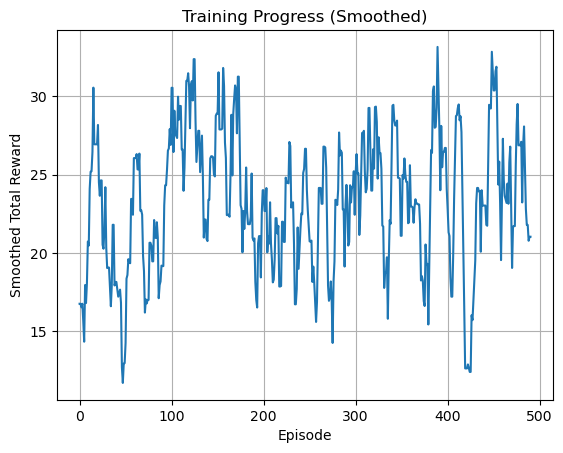

In [41]:
trained_agent, reward_curve = train_dqn(training_envs, num_episodes=500)

def smooth_curve(curve, window=10):
    return np.convolve(curve, np.ones(window)/window, mode='valid')

# Plot
smoothed = smooth_curve(reward_curve, window=10)
plt.plot(smoothed)
plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.title('Training Progress (Smoothed)')
plt.grid(True)